# The Higgs Boson Machine Learning Challenge 
Brighton Nkomo

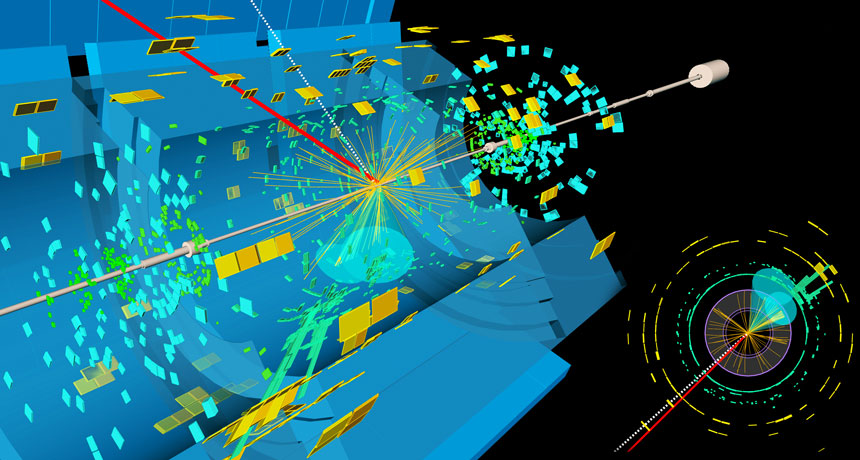

# Introduction 

The Higgs boson has many different processes through which it can decay. When it decays, it produces other particles. In physics, a decay into specific particles is called a _channel_. The Higgs boson has been seen first in three distinct decay channels which are all boson pairs. 

The dataset can be obtained from http://opendata.cern.ch/record/328 and has been built from official ATLAS full-detector simulation, with "Higgs to tautau" events mixed with different backgrounds. The simulator has two parts. In the first, random proton-proton collisions are simulated based on the knowledge that we have accumulated on particle physics. It reproduces the random microscopic explosions resulting from the proton-proton collisions. In the second part, the resulting particles are tracked through a virtual model of the detector. The process yields simulated events with properties that mimic the statistical properties of the real events with additional information on what has happened during the collision, before particles are measured in the detector.

The goal of this project is to essentially classify "tau tau decay of a Higgs boson" versus "background." So this is a binary classification issue and the desired metric to maximize is the _approximate median significance_ (AMS):

$$ \text{AMS} = \sqrt{2\left((s + b + b_r)\log \left( 1 + \frac{s}{b + b_r}\right) -s \right)}$$

where

\\(s, b\\): unnormalized true positive and false positive rates, respectively,
\\(b_r =10\\) is the constant regularization term,
\\(\log\\) is the natural log.
More precisely, let \\( y_1, \dotsc, y_n \in \{\text{b},\text{s}\}^n\\) be the vector of true test labels, let \\( \hat{y}_1, \dotsc, \hat{y}_n \in \{\text{b},\text{s}\}^n\\) be the vector of predicted _submitted_ test labels, and let \\( w_1, \dotsc, w_n \in {\mathbb{R}^+}^n\\) be the vector of weights. Then

$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}$$

and

$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$

where the indicator function \\(\mathbb{1}\{A\}\\) is 1 if its argument \\(A\\) is true and 0 otherwise.

__NB:__ I have chosen to work with with the [__Log Loss__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) metric, which is one of the most important classification metrics based on probabilities. Although it's hard to interpret raw log-loss values, but log-loss is still a good metric for comparing models. _For any given problem, a lower log loss value means better predictions_. 

# Importing Relevant Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn validation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Classification metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import label_binarize

# Keras 
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

import utils

# suppress cell warnings
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [ ]:
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [ ]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [ ]:
df.head(2)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584


Variable Descriptions: 
- EventId - An unique integer identifier of the event.
- DER_mass_MMC - The estimated mass mH of the Higgs boson candidate, obtained through a probabilistic phase space integration.
- DER_mass_transverse_met_lep - The transverse mass between the missing transverse energy and the lepton.
- DER_mass_vis - The invariant mass of the hadronic tau and the lepton.
- DER_pt_h - The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton and the missing transverse energy vector.
- DER_deltaeta_jet_jet - The absolute value of the pseudorapidity separation between the two jets (undefined if PRI_jet_num ≤ 1).
- DER_mass_jet_jet - The invariant mass of the two jets (undefined if PRI_jet_num $\le 1$).
- DER_prodeta_jet_jet - The product of the pseudorapidities of the two jets (undefined if PRI_jet_num $\le 1$).
- DER_deltar_tau_lep - The R separation between the hadronic tau and the lepton.
- DER_pt_tot - The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num $ \ge $) and the subleading jet (if PRI jet num $= 2$) (but not of any additional jets).
- DER_sum_pt - The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num $ \ge 1$) and the subleading jet (if PRI jet num $= 2$) and the other jets (if PRI jet num $= 3$).
- DER_pt_ratio_lep_tau - The ratio of the transverse momenta of the lepton and the hadronic tau.
- DER_met_phi_centrality - The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.
- DER_lep_eta_centrality - The centrality of the pseudorapidity of the lepton w.r.t. the two jets (undefined if PRI_jet_num $ \le 1$).
- PRI_tau_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the hadronic tau.
- PRI_tau_eta - The pseudorapidity $\eta$ of the hadronic tau.
- PRI_tau_phi - The azimuth angle $\phi$ of the hadronic tau.
- PRI_lep_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the lepton (electron or muon).
- PRI_lep_eta - The pseudorapidity $\eta$ of the lepton.
- PRI_lep_phi - The azimuth angle $\phi$ of the lepton.
- PRI_met - The missing transverse energy $ E \rightarrow missT$ 
- PRI_met_phi - The azimuth angle $\phi$ of the mssing transverse energy
- PRI_met_sumet - The total transverse energy in the detector.
- PRI_jet_num - The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3).
- PRI_jet_leading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is the jet with largest transverse momentum (undefined if PRI_jet_num $ = 0$).
- PRI_jet_leading_eta - The pseudorapidity $\eta$ of the leading jet (undefined if PRI jet num $= 0$).
- PRI_jet_leading_phi - The azimuth angle $\phi$ of the leading jet (undefined if PRI jet num $= 0$).
- PRI_jet_subleading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is, the jet with second largest transverse momentum (undefined if PRI_jet_num $\le 1$).
- PRI_jet_subleading_eta - The pseudorapidity $\eta$ of the subleading jet (undefined if PRI_jet_num $\le 1$).
- PRI_jet_subleading_phi - The azimuth angle $\phi$ of the subleading jet (undefined if PRI_jet_num $\le 1$).
- PRI_jet_all_pt - The scalar sum of the transverse momentum of all the jets of the events.
- Weight - The event weight $w_i$
- Label	The event label (string) \\( y_i \in \{\text{b},\text{s}\}\\) (s for signal, b for background).
- KaggleSet	- String specifying to which Kaggle set the event belongs : ”t”:training, ”b”:public leaderboard, ”v”:private leaderboard,”u”:unused.
- KaggleWeight - Weight normalised within each Kaggle dataset.

Since this notebook is not intended for the Kaggle competition, I will drop the KaggleSet and KaggleWeight columns. Also, the `EventId` is a redundant column and would only cause issues when trying to split the data with the stratified_shuffle_split validation method. It only exists for submission purposes.

In [ ]:
df.drop(['KaggleSet', 'KaggleWeight', 'EventId'], axis=1, inplace=True )
df.T.tail(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,818198,818199,818200,818201,818202,818203,818204,818205,818206,818207,818208,818209,818210,818211,818212,818213,818214,818215,818216,818217,818218,818219,818220,818221,818222,818223,818224,818225,818226,818227,818228,818229,818230,818231,818232,818233,818234,818235,818236,818237
PRI_jet_subleading_eta,1.24,-999,-999,-999,-999,0.224,0.131,-999,-999,-999,-999,1.773,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-0.798,-999,-999,-999,2.974,-999,-2.683,-999,-1.257,-1.985,-0.983,-999,-999,-999,-999,2.433,-2.385,...,-999,-0.332,-0.743,-999,-999,0.169,-999,-999,1.316,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,2.233,1.498,-0.504,-999,1.238,-999,-999,-999,-0.124,-1.384,-999,-999,0.787,-2.018,-999,-999,-999
PRI_jet_subleading_phi,-2.475,-999,-999,-999,-999,3.106,-2.767,-999,-999,-999,-999,-2.079,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-2.785,-999,-999,-999,-0.103,-999,-1.467,-999,-0.609,3.065,-2.628,-999,-999,-999,-999,-2.637,1.876,...,-999,-1.144,0.328,-999,-999,-2.291,-999,-999,2.818,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1.287,-2.218,0.832,-999,1.868,-999,-999,-999,-1.672,2.747,-999,-999,-1.09,2.893,-999,-999,-999
PRI_jet_all_pt,113.497,46.226,44.251,-0,0,193.66,179.877,30.638,0,167.735,0,165.64,93.117,0,0,-0,36.263,0,0,-0,0,0,0,278.009,0,-0,35.527,214.17,77.221,113.252,33.25,253.461,136.262,103.642,45.843,46.679,-0,-0,341.947,198.632,...,39.002,89.297,205.164,0,0,180.744,0,0,208.356,0,0,0,0,37.489,52.332,-0,126.319,0,0,48.125,-0,0,-0,140.28,250.408,369.304,37.855,90.118,38.654,210.299,0,136.986,320.076,110.841,-0,154.056,178.856,-0,30.863,-0
Weight,0.00081448,0.681042,0.715742,1.66065,1.90426,0.0254338,0.00081448,0.00572068,1.6148,0.000461025,0.701141,0.093659,0.51274,0.66589,0.655922,0.00572068,0.443598,0.000461282,1.56163,1.82316,0.670373,0.51274,1.39325,0.000461282,0.774979,0.51274,0.000461282,0.000461282,0.000461282,0.0944596,0.711032,0.000461282,0.000461282,0.346119,0.725754,0.51274,0.00572068,0.00572068,0.00572068,0.00081448,...,2.12415,0.336595,0.0944596,0.51274,1.52464,0.00081448,0.51274,0.67419,0.0225326,0.51274,0.925626,1.38584,0.00572068,0.51274,0.22687,0.90968,0.782818,0.00572068,0.636427,0.000461282,0.611755,0.51274,0.562147,0.000461282,0.000461282,0.22687,0.633648,0.00081448,0.00572068,0.00572068,1.43387,0.000461282,0.301427,0.0195328,1.43312,0.00572068,0.000461282,1.18936,0.51274,1.53121
Label,s,b,b,b,b,b,s,s,b,s,b,b,b,b,b,s,b,s,b,b,b,b,b,s,b,b,s,s,s,b,b,s,s,b,b,b,s,s,s,s,...,b,b,b,b,b,s,b,b,b,b,b,b,s,b,b,b,b,s,b,s,b,b,b,s,s,b,b,s,s,s,b,s,b,b,b,s,s,b,b,b


# Basic Insight of the Dataset

In [ ]:
df.dtypes

DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta            float64
PRI_jet_leading_phi      

In [ ]:
df.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,158.596159,1.438776,-0.127277,-708.306918,38.698152,-0.011663,-0.013158,46.692414,-0.019079,0.049460,41.654526,-0.008634,209.908730,0.979923,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594,0.503144
std,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,116.089809,0.845109,1.194235,453.909127,22.429016,1.213511,1.816083,22.142337,1.264250,1.815099,32.496113,1.812703,126.816686,0.978793,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754,0.572200
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.103000,0.047000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.051000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.000461
25%,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,77.492000,0.885000,-1.371000,-999.000000,24.586000,-0.926000,-1.584000,32.375000,-1.012000,-1.513000,21.383000,-1.574000,122.985000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.005721
50%,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,120.665000,1.281000,-0.356000,-999.000000,31.776000,-0.022000,-0.039000,40.543000,-0.040000,0.093000,34.768000,-0.019000,179.883000,1.000000,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000,0.357223
75%,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,200.884500,1.778000,1.228750,0.000000,44.919750,0.899000,1.559000,53.379000,0.957000,1.618000,51.912000,1.559000,263.828000,2.000000,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000,0.733462
max,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,2079.162000,32.228000,1.414000,1.000000,764.408000,2.500000,3.142000,701.328000,2.506000,3.142000,2842.617000,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316


In [ ]:
#df.info

In [ ]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

DER_mass_MMC
False    818238
Name: DER_mass_MMC, dtype: int64

DER_mass_transverse_met_lep
False    818238
Name: DER_mass_transverse_met_lep, dtype: int64

DER_mass_vis
False    818238
Name: DER_mass_vis, dtype: int64

DER_pt_h
False    818238
Name: DER_pt_h, dtype: int64

DER_deltaeta_jet_jet
False    818238
Name: DER_deltaeta_jet_jet, dtype: int64

DER_mass_jet_jet
False    818238
Name: DER_mass_jet_jet, dtype: int64

DER_prodeta_jet_jet
False    818238
Name: DER_prodeta_jet_jet, dtype: int64

DER_deltar_tau_lep
False    818238
Name: DER_deltar_tau_lep, dtype: int64

DER_pt_tot
False    818238
Name: DER_pt_tot, dtype: int64

DER_sum_pt
False    818238
Name: DER_sum_pt, dtype: int64

DER_pt_ratio_lep_tau
False    818238
Name: DER_pt_ratio_lep_tau, dtype: int64

DER_met_phi_centrality
False    818238
Name: DER_met_phi_centrality, dtype: int64

DER_lep_eta_centrality
False    818238
Name: DER_lep_eta_centrality, dtype: int64

PRI_tau_pt
False    818238
Name: PRI_tau_pt, dtype: int64

PR

It appears that this dataset has no missing values since and the CERN scientists might have replaced them with an outlier, in particular -999, that is not in the range of the values of the provided features.

In [ ]:
for column in df.columns.values.tolist():
    print(column)
    print (len(df[column].loc[df[column] == -999]))
    print("") 

DER_mass_MMC
124602

DER_mass_transverse_met_lep
0

DER_mass_vis
0

DER_pt_h
0

DER_deltaeta_jet_jet
580253

DER_mass_jet_jet
580253

DER_prodeta_jet_jet
580253

DER_deltar_tau_lep
0

DER_pt_tot
0

DER_sum_pt
0

DER_pt_ratio_lep_tau
0

DER_met_phi_centrality
0

DER_lep_eta_centrality
580253

PRI_tau_pt
0

PRI_tau_eta
0

PRI_tau_phi
0

PRI_lep_pt
0

PRI_lep_eta
0

PRI_lep_phi
0

PRI_met
0

PRI_met_phi
0

PRI_met_sumet
0

PRI_jet_num
0

PRI_jet_leading_pt
327371

PRI_jet_leading_eta
327371

PRI_jet_leading_phi
327371

PRI_jet_subleading_pt
580253

PRI_jet_subleading_eta
580253

PRI_jet_subleading_phi
580253

PRI_jet_all_pt
0

Weight
0

Label
0



Based on the summary above, each column has 818238 rows of data, eleven columns that were containing data replaced that has the outlier -999:
<ol>
    <li>"DER_mass_MMC": 124602 row values = -999</li>
    <li>"DER_deltaeta_jet_jet": 580253 row values = -999</li>
    <li>"DER_mass_jet_jet": 580253 row values = -999</li>
    <li>"DER_prodeta_jet_jet" : 580253 row values = -999</li>
    <li>"DER_lep_eta_centrality": 580253 row values = -999</li>
    <li>"PRI_jet_leading_pt": 327371 row values = -999</li>
    <li>"PRI_jet_leading_eta": 327371 row values = -999</li>
    <li>"PRI_jet_leading_phi": 327371 row values = -999</li>
    <li>"PRI_jet_subleading_pt": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_eta": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_phi": 580253 row values = -999</li>
</ol>

NB: For now, I will simply leave these outlier values in my data set.

# Data Visualization 

Now let's see how many rows are there labeled as 's' or 'b'. 

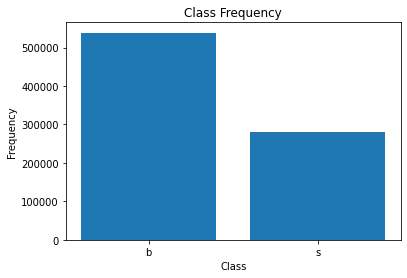

b    538678
s    279560
Name: Label, dtype: int64

In [ ]:
unique, counts = np.unique(df['Label'], return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=['b','s'], labels=['b','s'])
#plt.ylim(top=300)

plt.show()
df['Label'].value_counts()

As we can see there are 538678 events labeled as background-b and 279560 events are labeled as signal-s. We clearly have a class inbalance; about a third of the data is the signal-s and the remaining two-thirds of the data is the background-b.

Let's take a look at the correlation between features.

In [ ]:
# Calculate the correlation values
feature_cols = df.columns[:-1]
corr_values = df[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

Note that we are interested in the magnitude of the correlation between features, hence the reason why we should look at absolute correlations instead. In other words here, $\mid-0.8\mid = 0.8$. 

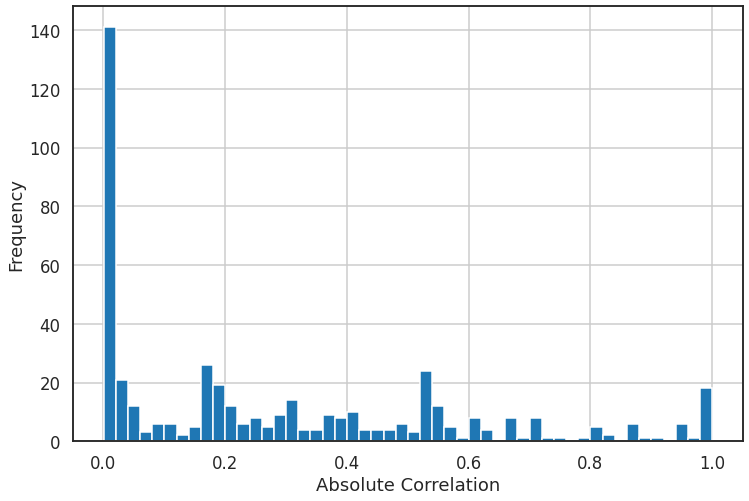

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

Most of the features have a zero correlation with other features. We are usually interested in features that are strongly correlated to each other or the target variable. Let's take a look at the features that are strongly correlated with each other next.

In [ ]:
# The 10 most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8').head(10)

,feature1,feature2,correlation,abs_correlation
121,DER_deltaeta_jet_jet,DER_lep_eta_centrality,0.999998,0.999998
309,DER_lep_eta_centrality,PRI_jet_subleading_phi,0.999998,0.999998
308,DER_lep_eta_centrality,PRI_jet_subleading_eta,0.999997,0.999997
137,DER_deltaeta_jet_jet,PRI_jet_subleading_phi,0.999996,0.999996
136,DER_deltaeta_jet_jet,PRI_jet_subleading_eta,0.999995,0.999995
459,PRI_jet_subleading_eta,PRI_jet_subleading_phi,0.999995,0.999995
444,PRI_jet_leading_eta,PRI_jet_leading_phi,0.999992,0.999992
170,DER_prodeta_jet_jet,DER_lep_eta_centrality,0.999990,0.999990
186,DER_prodeta_jet_jet,PRI_jet_subleading_phi,0.999989,0.999989
185,DER_prodeta_jet_jet,PRI_jet_subleading_eta,0.999988,0.999988


In [ ]:
corr_values.shape

(465, 4)

There are 465 pairs of features that show strong positive/negative correlation (i.e, absolute correlation vlaues greater than 0.8) 

# Pre-processing

In [ ]:
set(df.Label)

{'b', 's'}

In [ ]:
df['Class'] = utils.get_class_ids(df.Label.values)
set(df.Class)

{0, 1}

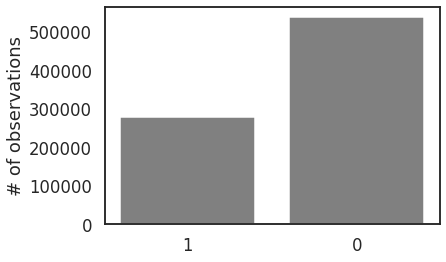

In [ ]:
# Get all possible labels
labels = df.Class.unique()
heights = [len(df[df.Class==i]) for i in set(df.Class)] 
plt.bar(labels,heights,color='grey')
plt.xticks(labels,list(set(df.Class)))
plt.ylabel("# of observations")
plt.show()

In [ ]:
features = list(set(df.columns) - {'Label', 'Class'})
features

['PRI_lep_pt',
 'DER_pt_tot',
 'PRI_jet_subleading_pt',
 'PRI_lep_phi',
 'DER_sum_pt',
 'PRI_tau_phi',
 'Weight',
 'PRI_met_sumet',
 'PRI_jet_num',
 'DER_deltar_tau_lep',
 'DER_mass_jet_jet',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_met',
 'DER_lep_eta_centrality',
 'DER_mass_transverse_met_lep',
 'PRI_met_phi',
 'DER_deltaeta_jet_jet',
 'DER_mass_vis',
 'DER_prodeta_jet_jet',
 'PRI_lep_eta',
 'PRI_tau_eta',
 'PRI_jet_subleading_phi',
 'DER_met_phi_centrality',
 'DER_pt_ratio_lep_tau',
 'PRI_jet_all_pt',
 'PRI_tau_pt',
 'DER_mass_MMC',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_eta',
 'DER_pt_h']

In [ ]:
df.Label.values

array(['s', 'b', 'b', ..., 'b', 'b', 'b'], dtype=object)

In [ ]:
# from sklearn.feature_selection import mutual_info_classif

# discrete_features = df[features].dtypes == int
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(df[features], df.Class, discrete_features)
# mi_scores[::3]  # show a few features with their MI scores

In [ ]:
# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(20, 14))
# plot_mi_scores(mi_scores)

The `'Weight'` feature contains info about the target variable `'Class'`. Including this feature in our models would lead to a [__data leakage__](https://www.kaggle.com/alexisbcook/data-leakage). This would lead to perfect classifiers. Without removing the weight feature, the models are overly optimistic and the logistic regression model with either L1-regularization or L2-regularization would lead to perfect classifiers. The data leakage could be expained by the following formulas defined at the begining of this notebook: 

Recall that \\( w_1, \dotsc, w_n \in {\mathbb{R}^+}^n\\) is the vector of weights and that

$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}$$

and

$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$

where the indicator function \\(\mathbb{1}\{A\}\\) is 1 if its argument \\(A\\) is true and 0 otherwise.

It is clear to see that knowing $w_i$ would tell us something about the events being signal 's' or background 'b'. Hence the `Weight` column should be dropped from the features list.


In [ ]:
features = list(set(features) - {'Weight'})
features

['DER_deltaeta_jet_jet',
 'PRI_lep_pt',
 'DER_pt_tot',
 'PRI_jet_subleading_pt',
 'DER_mass_vis',
 'DER_prodeta_jet_jet',
 'PRI_lep_phi',
 'PRI_lep_eta',
 'PRI_tau_eta',
 'DER_sum_pt',
 'PRI_jet_subleading_phi',
 'PRI_tau_phi',
 'DER_met_phi_centrality',
 'PRI_met_sumet',
 'DER_pt_ratio_lep_tau',
 'PRI_jet_num',
 'PRI_jet_all_pt',
 'DER_deltar_tau_lep',
 'DER_mass_jet_jet',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_met',
 'PRI_tau_pt',
 'DER_mass_MMC',
 'DER_lep_eta_centrality',
 'DER_mass_transverse_met_lep',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_eta',
 'PRI_met_phi',
 'DER_pt_h']

### Dividing the data into two parts

Since we have an imbalanced dataset, I'll use a stratified shuffle split to maintain the same ratio of classes in the train and validation data.

In [ ]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.33, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[features], df.Class))

# Create the dataframes
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'Class']

X_test  = df.loc[test_idx, features]
y_test  = df.loc[test_idx, 'Class']

In [ ]:
# define the scaler
scaler = MinMaxScaler()
# fit on the training dataset
scaler.fit(X_train)
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

In [ ]:
len(X_train), len(X_test)

(548219, 270019)

# Model Building

### Sklearn Classifiers

Now let's look at which model performs best at classifying events in the validation sample. I will seperate this section into 2 parts:
- 1. Linear and non-linear models 
- 2. Tree-based models

### 1. Linear Model: 
#### 1.1 Logistic Regression

In [ ]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [ ]:
%%time

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

CPU times: user 48min 14s, sys: 3.54 s, total: 48min 18s
Wall time: 48min 6s


In [ ]:
%%time
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

CPU times: user 13min 8s, sys: 2.47 s, total: 13min 10s
Wall time: 13min 8s


In [ ]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

In [ ]:
y_prob.head()

,lr,l1,l2
0,0.866695,0.865441,0.865970
1,0.500776,0.502584,0.500711
2,0.568148,0.545969,0.529731
3,0.506846,0.511152,0.534796
4,0.870726,0.878515,0.878631


In [ ]:
log_loss(y_test, y_pred['l1'])

8.641064996540237

In [ ]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [ ]:
metrics

,lr,l1,l2
precision,0.741422,0.741909,0.742002
recall,0.749507,0.749818,0.749899
fscore,0.740560,0.741562,0.741666
accuracy,0.749507,0.749818,0.749899
auc,0.694577,0.696568,0.696708


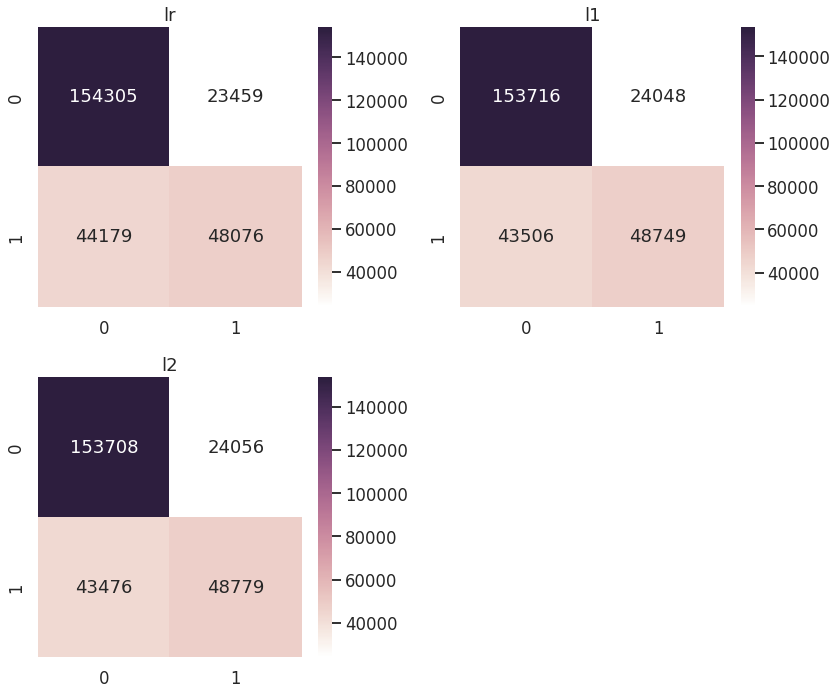

In [ ]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=cmap);
    ax.set(title=lab);
    
plt.tight_layout()

The linear regression model using the L1-regularization technique, also called Lasso Regression, clearly outpeforms the other two models.

### 2. Tree-Based Model: Boosted Decision Tree

In [ ]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400, subsample=0.3, random_state=13,
                                min_samples_leaf=10, max_depth=30)
gb.fit(X_train, y_train)

In [ ]:
# predict each event
proba_gb = gb.predict_proba(X_test)

In [ ]:
log_loss(y_test, proba_gb)

### 3. Keras Neural Network 

In [ ]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [ ]:
nn = nn_model(len(features))
nn.fit(X_train, np_utils.to_categorical(y_train), verbose=1, epochs=10, batch_size=256)

### Log loss on the cross validation sample

In [ ]:
# predict each event
proba_nn = nn.predict(X_test)

In [ ]:
log_loss(y_test, proba_nn)

NB: this neural network still needs some tuning, it's just a baseline model and a quick check that all is working well in Keras.

# Quality Metrics

    Now I'll plot ROC curves and signal efficiency dependence from particle mometum and transverse momentum values.

In [ ]:
import utils

In [ ]:
proba = proba_gb

In [ ]:
utils.plot_roc_curves(proba, y_test)

In [ ]:
utils.plot_signal_efficiency_on_pt(proba, y_test, X_test[PRI_tau_pt], 60, 50)
plt.show()